## Installing and importing libraries

In [1]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 872.4 kB/s eta 0:00:00


In [2]:
import torchvision
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
import time
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

torch.set_printoptions(linewidth=120)

## Dataset generation

### Seed images

Collect seed images from each class such that there are k images per class. These seed images will be later augmented to form the entire dataset.

In [3]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

def get_seed_images(k=1, n_classes=10):
  class_list = []
  final_classes = []
  mean = 0.2859;  std = 0.3530
  train_set = torchvision.datasets.FashionMNIST(root="./", download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)]))
  for _ in range(k):
    for i in range(n_classes):
      class_list.append(i)
  dataloader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True, num_workers=1)
  rand_images = torch.zeros(k * n_classes, 1, 28, 28)

  j=0
  for images, targets in dataloader:
    for i in range(images.shape[0]):
      if targets[i] in class_list:
        rand_images[j] = images[i]
        j += 1
        class_list.remove(targets[i])
        final_classes.append(targets[i].item())

        if class_list == []:
          break

  return rand_images, final_classes

images, classes = get_seed_images(k=1)

image tensor: torch.Size([10, 1, 28, 28])


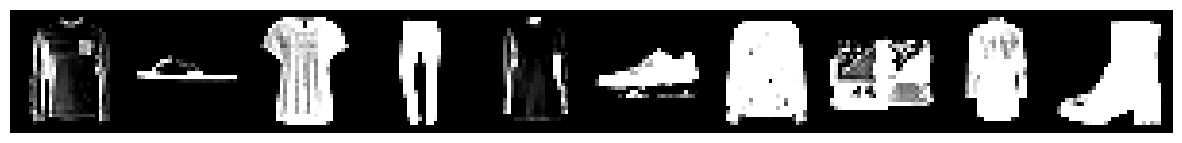

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
grid = torchvision.utils.make_grid(nrow=10, tensor=images)
print(f"image tensor: {images.shape}")
plt.axis('off')
plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray');


### Augment function

The augment function modifies the seed images (28x28) and produces a new image that has a larger size than the seed image (40x40), contains the subject of the seed image in a random position in this larger grid and the background is populated with random pixel values.

In [ ]:
def augment(device, imgs):
  
  mask = imgs.le(-0.8)
  random_patch = torch.rand(imgs.shape[0], 1, 28, 28).to(device)
  random_patch[mask] = imgs[mask] 

  random_grid = torch.rand(imgs.shape[0], 1, 39, 39).to(device)

  new_x = np.random.randint(0, 12)
  new_y = np.random.randint(0, 12)

  random_grid[:,:,new_x:new_x+28,new_y:new_y+28] = imgs 

  return random_grid

### Putting it all together

In [ ]:
import einops

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed_images = images.to(device) #get_seed_images().to(device)

n = 10         #size of generated dataset = n x n_classes
n_classes = 10

dataset_images = torch.zeros(n*n_classes,1,39,39) 
dataset_labels = einops.repeat(torch.arange(10), 'n -> (repeat n)', repeat=n)

for i in range(n):
  new_images = augment(device, seed_images)
  dataset_images[10*i:10*i+10] = new_images

image tensor: torch.Size([10, 1, 39, 39])
labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


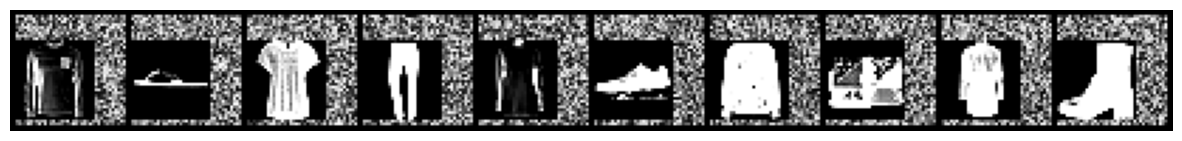

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
grid = torchvision.utils.make_grid(nrow=10, tensor=dataset_images[:10])
print(f"image tensor: {dataset_images[:10].shape}")
print(f"labels: {dataset_labels[:10]}")
plt.axis('off')
plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray');


### Dataset class for augmented dataset and splitting dataset 

In [ ]:
class Augmented_Dataset(torch.utils.data.Dataset):
  def __init__(self, images, labels):

        self.images = images
        self.labels = labels

  def __len__(self):
      return len(self.images)

  def __getitem__(self, idx):
      if torch.is_tensor(idx):
          idx = idx.tolist()

      image = self.images[idx]
      label = self.labels[idx]

      return image, label

dataset = Augmented_Dataset(dataset_images, dataset_labels)

In [ ]:
train_idx, validation_idx = train_test_split(np.arange(len(dataset)),
                                             test_size=0.1,
                                             random_state=999,
                                             shuffle=True,
                                             stratify=dataset.labels)

train_dataset = Subset(dataset, train_idx)
validation_dataset = Subset(dataset, validation_idx)

In [ ]:
import pandas as pd

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=90, shuffle=True, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=10, shuffle=False, num_workers=1)

for _, lbl in train_dataloader:
  print('Training Set')
  print(pd.Series(lbl).value_counts())

for _, lbl in test_dataloader:
  print('Test set')
  print(pd.Series(lbl).value_counts())


Training Set
2    9
0    9
4    9
3    9
7    9
8    9
9    9
1    9
6    9
5    9
dtype: int64
Test set
8    1
9    1
5    1
3    1
0    1
2    1
1    1
7    1
6    1
4    1
dtype: int64
